In [1]:
import warnings
warnings.filterwarnings('ignore') 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm

import re 
from nltk.corpus import stopwords 
from collections import Counter 
from string import punctuation 
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch 
import torch.nn as nn 
from torch.optim import Adam 
from torch.utils.data import DataLoader , TensorDataset 
from torchinfo import summary 
from torchmetrics.text import BLEUScore

2024-05-25 21:35:59.779237: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 21:36:00.925237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cpu device


In [3]:
# Define the path to the dataset file
input_file = '/home/ciprian/Pythonvscode/Pythonprograms/hin.txt'
output_file = 'path_to_output_file.txt'

# Function to preprocess the dataset
def preprocess_dataset(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
        for line in infile:
            # Each line contains a translation pair followed by metadata, separated by '\t'
            parts = line.split('\t')
            if len(parts) >= 2:
                src_sentence = parts[0].strip()  # Extract the source sentence
                trg_sentence = parts[1].strip()  # Extract the target sentence
                # Write the source and target sentence to the output file
                outfile.write(f"{src_sentence}\t{trg_sentence}\n")
    print(f"Preprocessing completed. The output file is saved as {output_file}")

# Call the preprocessing function
preprocess_dataset(input_file, output_file)


Preprocessing completed. The output file is saved as path_to_output_file.txt


In [4]:
# Assuming data_file contains lines of sentence pairs separated by a tab (source \t target)
data_file = open('/home/ciprian/Pythonvscode/Pythonprograms/path_to_output_file.txt','r').read()
lines = data_file.strip().split('\n')
src_texts, trg_texts = zip(*[line.split('\t') for line in lines])

df = pd.DataFrame({'src': src_texts, 'trg': trg_texts})

df['src_len'] = [len(text.split()) for text in df.src] 
df['trg_len'] = [len(text.split()) for text in df.trg] 

df.head()

,src,trg,src_len,trg_len
0,Wow!,वाह!,1,1
1,Duck!,झुको!,1,1
2,Duck!,बतख़!,1,1
3,Help!,बचाओ!,1,1
4,Jump.,उछलो.,1,1


(-0.5, 1999.5, 1599.5, -0.5)

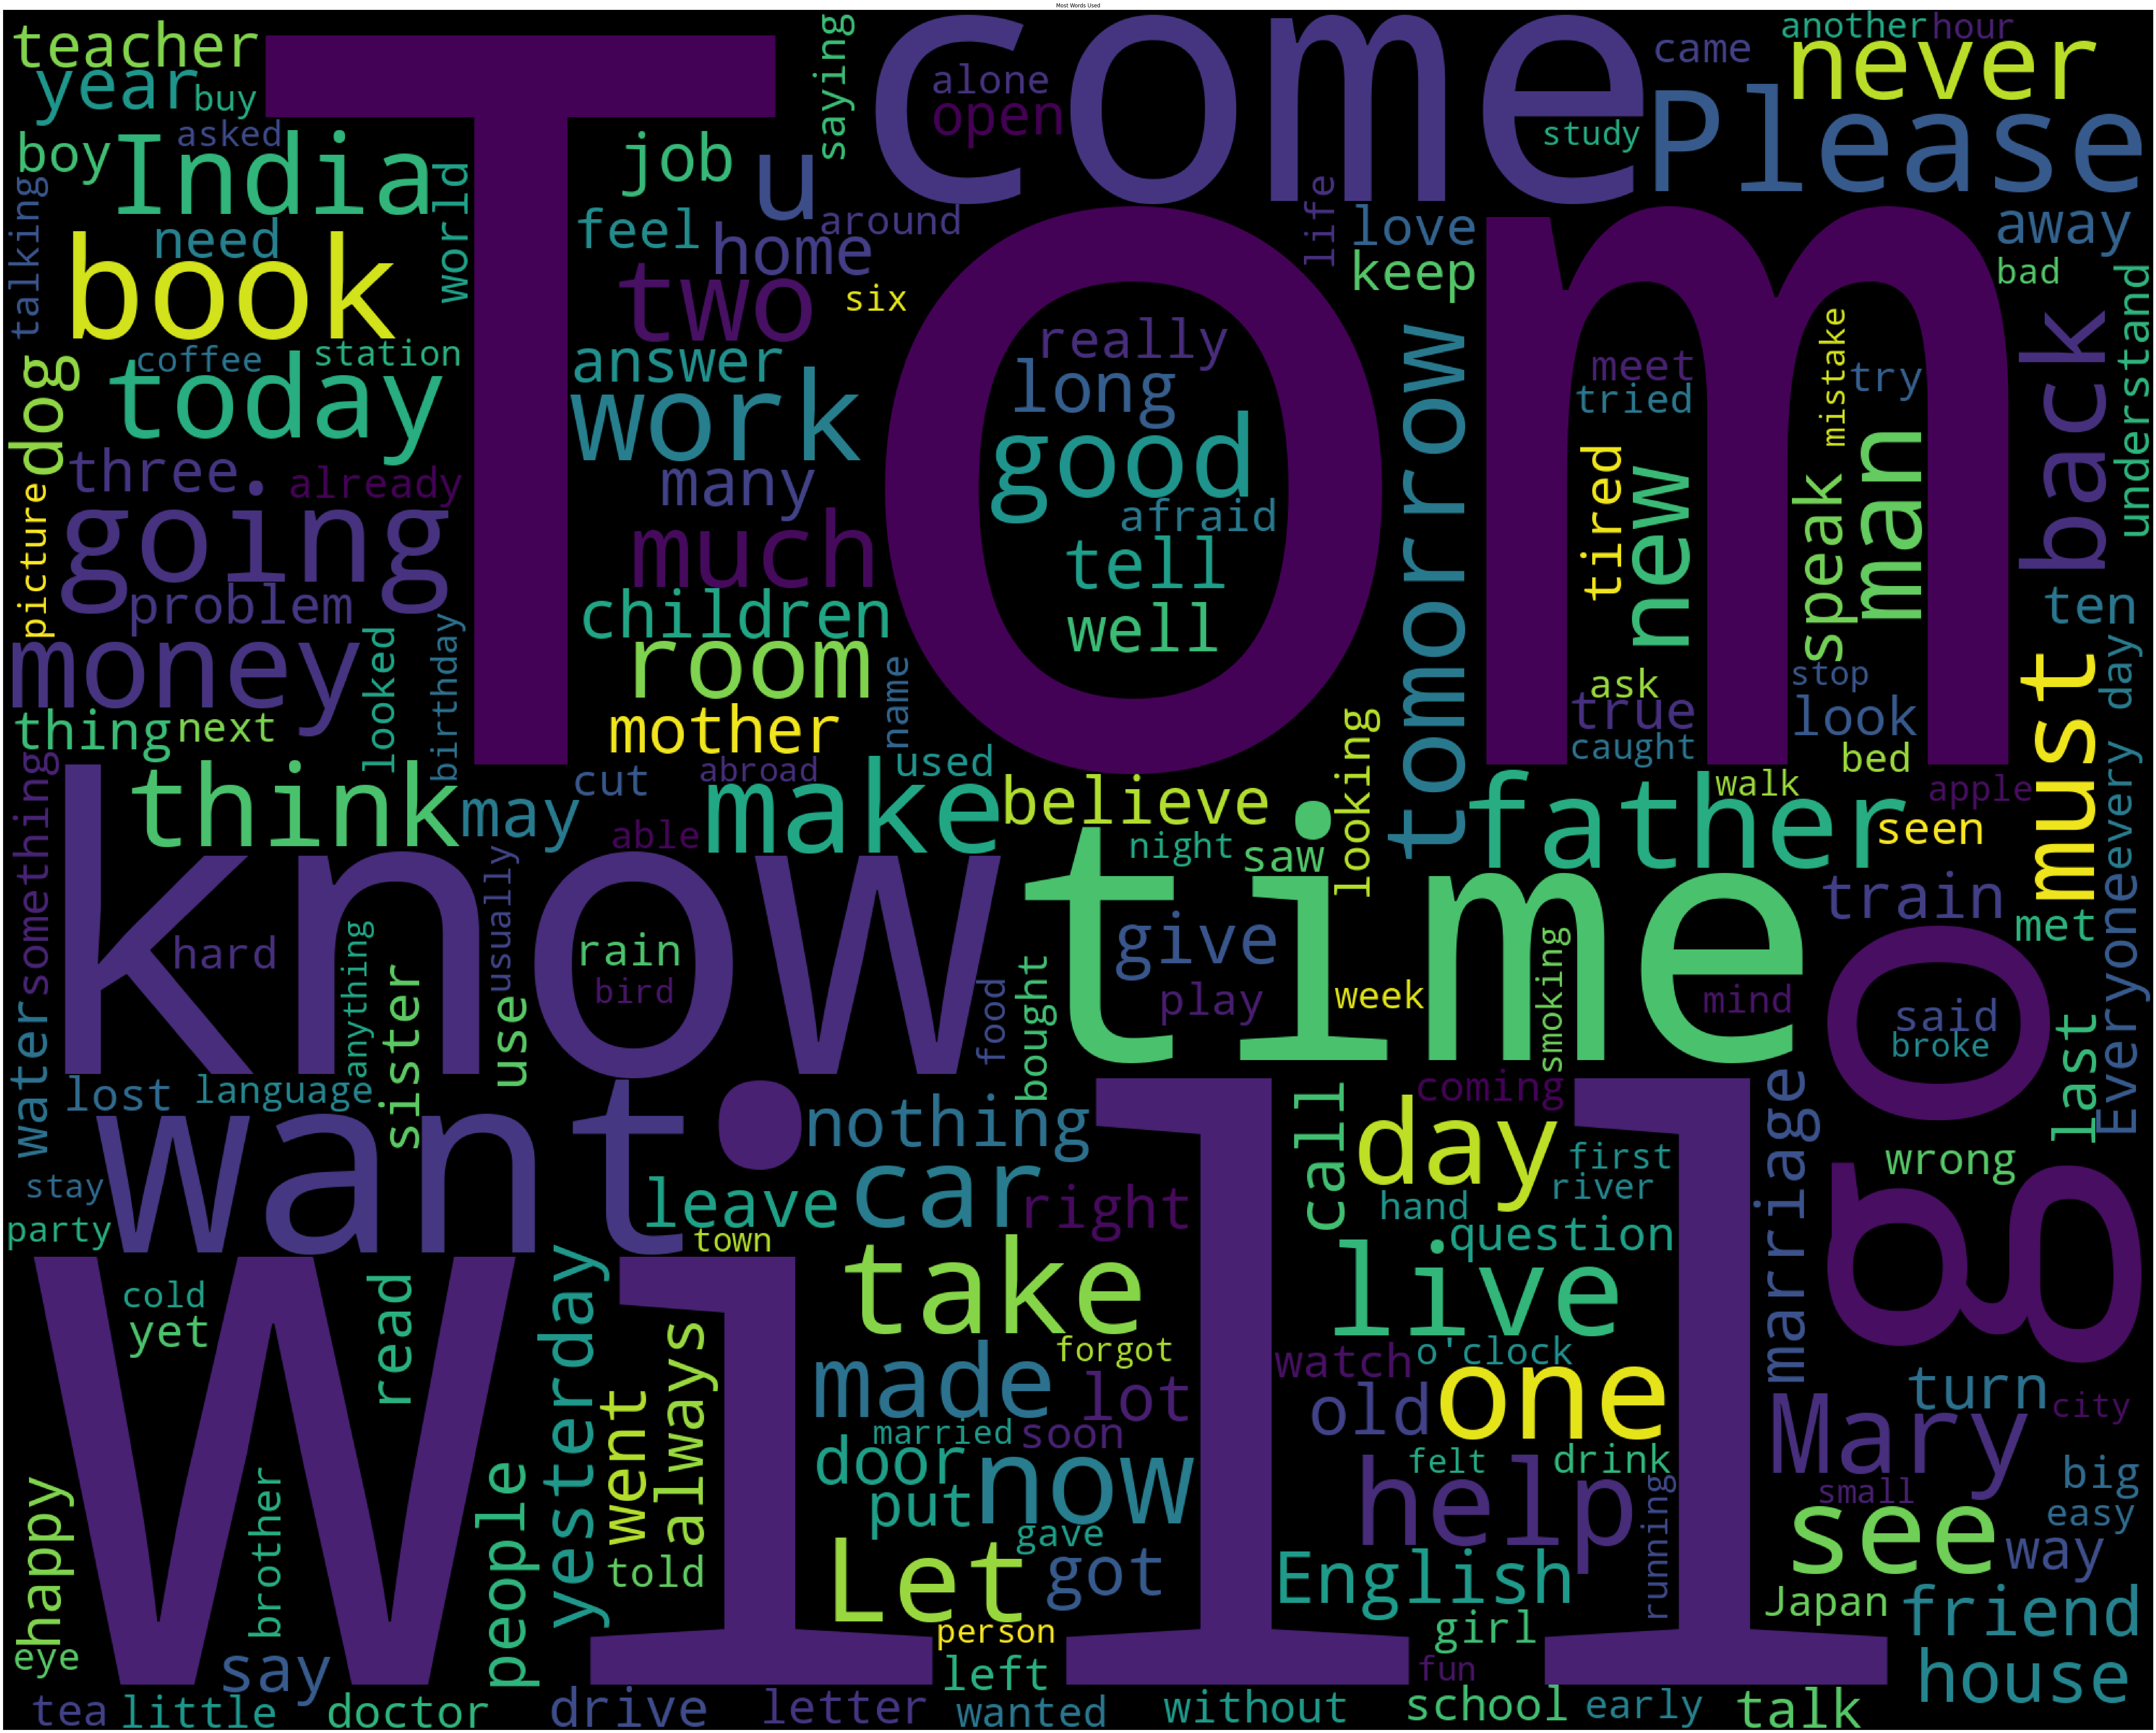

In [5]:
MostWordsUsed = WordCloud(
                          background_color='black',
                          width=2000,
                          height=1600
                         ).generate(' '.join(df['src']))

plt.figure(figsize=(90,90))
plt.imshow(MostWordsUsed) 
plt.title('Most Words Used') 
plt.axis('off')

In [6]:
def src_preprocessing(data , col) : 
    data[col] = data[col].astype(str) 
    data[col] = data[col].apply(lambda x: x.lower())
    data[col] = data[col].apply(lambda x: re.sub("[^A-Za-z\s]","",x)) 
    data[col] = data[col].apply(lambda x: re.sub("\s+"," ",x))
    data[col] = data[col].apply(lambda x: " ".join([word for word in x.split()]))
    return data 

def trg_preprocessing(data , col) : 
    data[col] = data[col].astype(str) 
    data[col] = data[col].apply(lambda x : x.lower()) 
    data[col] = data[col].apply(lambda x: re.sub(r'\d','',x))
    data[col] = data[col].apply(lambda x: re.sub(r'\s+',' ',x))
    data[col] = data[col].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,।]", "", x))
    data[col] = data[col].apply(lambda x: x.strip()) 
    data[col] = "<sos> " + data[col] + " <eos>" 
    return data

In [7]:
df = src_preprocessing(df , 'src') 
df = trg_preprocessing(df , 'trg')

In [8]:
df = df[~(df['src_len'] < 5) & ~(df['src_len'] > 19)] 
df = df[~(df['trg_len'] < 5) & ~(df['trg_len'] > 19)]

In [9]:
np.min(df['src_len']) , np.min(df['trg_len'])

(5, 5)

In [10]:
np.max(df['src_len']) , np.max(df['trg_len'])

(18, 19)

In [11]:
SRC_MAXLEN = np.max(df['src_len'])
TRG_MAXLEN = np.max(df['trg_len'])

In [12]:
def Vectorization(col , MAXLEN) : 
    sents = df[col].tolist() 
    
    # build vocabulary 
    corpus = [word for text in df[col] for word in text.split()] 
    vocab_size = len(Counter(corpus)) 
    
    tokenizer = Tokenizer(num_words=vocab_size , oov_token = "<OOV>" , 
                          filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'
                         )
    
    tokenizer.fit_on_texts(sents) 
    
    # Adding special tokens
    tokenizer.word_index['<pad>'] = 0 
    tokenizer.index_word[0] = '<pad>'
    tokenizer.word_index['<sos>'] = len(tokenizer.word_index) + 1
    tokenizer.index_word[tokenizer.word_index['<sos>']] = '<sos>'
    tokenizer.word_index['<eos>'] = len(tokenizer.word_index) + 1
    tokenizer.index_word[tokenizer.word_index['<eos>']] = '<eos>'
    
    vocab_to_idx = tokenizer.word_index 
    idx_to_vocab = tokenizer.index_word 
    
    # Text Vectorization 
    seqs = tokenizer.texts_to_sequences(sents) 
    
    pad_seqs = pad_sequences(seqs , maxlen = MAXLEN , padding = 'post') 
    
    return pad_seqs , tokenizer

In [13]:
def trg_preprocessing(data , col) : 
    data[col] = data[col].astype(str) 
    data[col] = data[col].apply(lambda x : x.lower()) 
    data[col] = data[col].apply(lambda x: re.sub(r'\d','',x))
    data[col] = data[col].apply(lambda x: re.sub(r'\s+',' ',x))
    data[col] = data[col].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,।]", "", x))
    data[col] = data[col].apply(lambda x: x.strip()) 
    data[col] = "<sos> " + data[col] + " <eos>" 
    return data

In [14]:
df = src_preprocessing(df , 'src') 
df = trg_preprocessing(df , 'trg')


In [15]:
src_seqs , src_tokenizer = Vectorization('src' , SRC_MAXLEN)
trg_seqs , trg_tokenizer = Vectorization('trg' , TRG_MAXLEN)

In [16]:
print(f"The size of the source vocab size : {len(src_tokenizer.word_index)}\n")
print(f"The size of the target vocab size : {len(trg_tokenizer.word_index)}\n")

The size of the source vocab size : 2206

The size of the target vocab size : 2621



In [17]:
trg_sent = ' '.join([trg_tokenizer.index_word[idx] for idx in trg_seqs[15] if idx != 0])  
print(f"{trg_seqs[15]} \n\n {trg_sent}")

[  2   2   7  62 391 342  26   3   3   0   0   0   0   0   0   0   0   0
   0] 

 sos sos मैं तुम्हारे जितना लम्बा हूँ eos eos


# <b>5 <span style='color:#9146ff'>|</span> Data Pipeline</b>

In [18]:
BATCH_SIZE = 512

In [19]:
ds = TensorDataset(torch.LongTensor(src_seqs) , torch.LongTensor(trg_seqs))

In [20]:
torch.manual_seed(42) 
ds_dataloader = DataLoader(
    dataset = ds , 
    batch_size = BATCH_SIZE , 
    shuffle = True , 
    num_workers = 4 , 
    pin_memory = True
)

In [21]:
print(f"the size of the dataloader {len(ds_dataloader)} batches of {BATCH_SIZE}")

the size of the dataloader 5 batches of 512


# <b>6 <span style='color:#9146ff'>|</span> Build our model</b>

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>1-</b> Self Attention</span>

In [22]:
def SelfAttention(q , k , v , mask) : 
    # attention weights 
    attention_logits = torch.matmul(q , k.transpose(-2 , -1)).to(DEVICE) 
    
    # number of embedding values 
    scaling = torch.sqrt(torch.tensor(k.size(-1) , dtype = torch.float32)).to(DEVICE) 
    
    # scaled attention weights 
    scaled_attention_logits = attention_logits / scaling 
    
    # Apply mask to the attention weights (if mask is not None)
    if mask is not None : 
        scaled_attention_logits += (mask * -1e9) 
        
    # apply softmax 
    attention_weights = torch.softmax(scaled_attention_logits, dim=-1).to(DEVICE) 
    
    # Compute the weighted sum of the value vectors using the attention weights  
    output = torch.matmul(attention_weights , v).to(DEVICE) 
    
    return output

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>2-</b> Multi-Head Attention</span>

In [23]:
class MultiHeadAttention(nn.Module) : 
    def __init__(self , embedding_dim , num_heads) : 
        super(MultiHeadAttention , self).__init__() 
        
        self.embedding_dim = embedding_dim 
        self.num_heads = num_heads 
        
        # Embedding size needs to be divisible by heads
        assert self.embedding_dim % self.num_heads == 0 
        
        self.head_dim = self.embedding_dim // self.num_heads 
        
        self.queries = nn.Linear(embedding_dim , embedding_dim) 
        self.keys = nn.Linear(embedding_dim , embedding_dim) 
        self.values = nn.Linear(embedding_dim , embedding_dim) 
        self.fc_out = nn.Linear(embedding_dim , embedding_dim) 
        
    def split_heads(self , x , batch_size) : 
        x = x.reshape(batch_size , -1 , self.num_heads , self.head_dim) 
        return x.permute(0, 2, 1, 3) # (batch_size , num_heads , seqlen , head_dim) 
    
    def forward(self , q , k , v , mask = None) : 
        batch_size = q.shape[0] 
        
        # (q , k , v) shape: (batch_size , seqlen , embedding_dim)
        q = self.queries(q) 
        k = self.keys(k) 
        v = self.values(v)
        
        q = self.split_heads(q , batch_size) 
        k = self.split_heads(k , batch_size) 
        v = self.split_heads(v , batch_size) 
        
        # scaled_attention shape : (batch_size , num_heads , seqlen_q , head_dim) 
        scaled_attention = SelfAttention(q , k , v , mask) 
        
        scaled_attention = scaled_attention.permute(0 , 2 , 1 , 3) # (batch_size  , seqlen_q , num_heads , head_dim)
        
        # Concatenation of heads 
        attention_output = scaled_attention.reshape(batch_size, -1, self.embedding_dim)  # (batch_size, seq_len_q, embedding_dim) 
        
        out = self.fc_out(attention_output) # (batch_size , seqlen_q , embedding_dim)
        
        return out

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>3-</b> Encoder</span>

In [24]:
class EncoderBlock(nn.Module) : 
    def __init__(self , embedding_dim , num_heads , fc_dim , dropout_rate = 0.1) : 
        super(EncoderBlock , self).__init__() 
        
        self.MHA = MultiHeadAttention(embedding_dim , num_heads) 
        
        self.norm1 = nn.LayerNorm(embedding_dim , eps=1e-6) 
        self.norm2 = nn.LayerNorm(embedding_dim , eps=1e-6) 
        
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate) 
        
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim , fc_dim) , 
            nn.ReLU() , 
            nn.Linear(fc_dim , embedding_dim)
        )
        
    def forward(self , x , mask) : 
        attn_out = self.MHA(x , x , x , mask)  
        attn_out = self.dropout1(attn_out) 
        
        out1 = self.norm1(x + attn_out)  
        
        fc_out = self.dropout2(self.fc(out1))  
        
        enc_out = self.norm2(out1 + fc_out)  
        
        return enc_out # (batch_size , seqlen , embedding_dim)

In [25]:
class Encoder(nn.Module) : 
    def __init__(
        self , 
        num_layers , 
        embedding_dim , 
        num_heads , 
        fc_dim , 
        src_vocab_size , 
        max_length , 
        dropout_rate = 0.1
    ) : 
        super(Encoder , self).__init__() 
        
        self.num_layers = num_layers  
        
        self.embedding = nn.Embedding(src_vocab_size , embedding_dim) 
        
        self.pos_encoding = nn.Embedding(max_length , embedding_dim) 
        
        self.enc_layers = [EncoderBlock(embedding_dim , num_heads , fc_dim , dropout_rate).to(DEVICE)
                          for _ in range(num_layers)] 
        
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self , x , mask) : 
        batch_size , seqlen = x.shape 
        
        positions = torch.arange(0, seqlen).expand(batch_size, seqlen).to(DEVICE)  
        
        out = self.dropout((self.embedding(x) + self.pos_encoding(positions))) 
        
        for i in range(self.num_layers) : 
            out = self.enc_layers[i](out , mask) 
            
        return out # (batch_size , seqlen , embedding_dim)

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>4-</b> Decoder</span>

In [26]:
class DecoderBlock(nn.Module) : 
    def __init__(self , embedding_dim , num_heads , fc_dim , dropout_rate = 0.1) : 
        super(DecoderBlock , self).__init__()  
        
        self.MHA1 = MultiHeadAttention(embedding_dim , num_heads) 
        self.MHA2 = MultiHeadAttention(embedding_dim , num_heads)
        
        self.norm1 = nn.LayerNorm(embedding_dim , eps=1e-6) 
        self.norm2 = nn.LayerNorm(embedding_dim , eps=1e-6)
        self.norm3 = nn.LayerNorm(embedding_dim , eps=1e-6)
        
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate) 
        
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim , fc_dim) , 
            nn.ReLU() , 
            nn.Linear(fc_dim , embedding_dim)
        )
        
        
    def forward(self , x , enc_output , look_ahead_mask , padding_mask) : 
        # enc_output shape : (batch_size , seqlen , embedding_dim) 
        
        attn1 = self.MHA1(x , x , x , look_ahead_mask) 
        attn1 = self.dropout1(attn1) 
        out1 = self.norm1(attn1 + x)  
        
        attn2 = self.MHA2(out1 , enc_output , enc_output , padding_mask) 
        attn2 = self.dropout2(attn2)
        out2 = self.norm2(attn2 + out1)  
        
        fc_out = self.dropout3(self.fc(out2)) 
        dec_out = self.norm3(fc_out + out2) 
        
        return dec_out # (batch_size , seqlen , embedding_dim)

In [27]:
class Decoder(nn.Module) : 
    def __init__(
        self , 
        num_layers , 
        embedding_dim , 
        num_heads , 
        fc_dim , 
        trg_vocab_size , 
        max_length , 
        dropout_rate = 0.1 
    ) : 
        super(Decoder , self).__init__() 
        
        self.num_layers = num_layers  
        
        self.embedding = nn.Embedding(trg_vocab_size , embedding_dim) 
        
        self.pos_encoding = nn.Embedding(max_length , embedding_dim) 
        
        self.dec_layers = [DecoderBlock(embedding_dim , num_heads , fc_dim , dropout_rate).to(DEVICE)
                          for _ in range(num_layers)] 
        
        self.dropout = nn.Dropout(dropout_rate) 
        
    def forward(self , x , enc_output , look_ahead_mask , padding_mask) : 
        batch_size , seqlen = x.shape 
        
        positions = torch.arange(0, seqlen).expand(batch_size, seqlen).to(DEVICE)  
        
        out = self.dropout((self.embedding(x) + self.pos_encoding(positions))) 
        
        for i in range(self.num_layers) : 
            out  = self.dec_layers[i](out , enc_output , look_ahead_mask , padding_mask)
            
        
        return out # (batch_size , seqlen , embedding_dim)

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>5-</b> Transformer</span>

In [28]:
class Transformer(nn.Module) : 
    def __init__(
        self ,
        num_layers , 
        embedding_dim , 
        num_heads , 
        fc_dim , 
        src_vocab_size , 
        trg_vocab_size , 
        src_max_length , 
        trg_max_length , 
        dropout_rate = 0.1 
    ) : 
        super(Transformer , self).__init__() 
        
        self.encoder = Encoder(
            num_layers , 
            embedding_dim , 
            num_heads , 
            fc_dim , 
            src_vocab_size , 
            src_max_length , 
            dropout_rate 
        ).to(DEVICE)
        
        self.decoder = Decoder(
            num_layers , 
            embedding_dim , 
            num_heads , 
            fc_dim , 
            trg_vocab_size , 
            trg_max_length , 
            dropout_rate
        ).to(DEVICE)
        
        self.fc_out = nn.Linear(embedding_dim , trg_vocab_size) 
        
    def padding_mask(self , seq) : 
        # Mask all the pad tokens in the batch of sequence.
        # It ensures that the model does not treat padding as the input.
        #The mask indicates where pad value 0 is present: it outputs a 1 at those locations,and a 0 otherwise.
    
        # seq shape : (batch_size , seqlen)  -> (batch_size , 1 , 1 , seq_len)
        
        seq_mask = (seq == 0).float().unsqueeze(1).unsqueeze(2) 
        
        return seq_mask
    
    
    def look_ahead_mask(self , trg) : 
        # The look-ahead mask is used to mask the future tokens in a sequence. In other words,
        # the mask indicates which entries should not be used
    
        # Returns a lower triangular matrix filled with 1s. The shape of the mask is (target_size, target_size)
        # tensor([[[[0., 1., 1.],
                  #  [0., 0., 1.],
                  #  [0., 0., 0.]]]])
                
        batch_size , trg_len = trg.shape 
        
        trg_mask = 1 - torch.tril(torch.ones((trg_len , trg_len)) , diagonal=0).expand(
            batch_size, 1, trg_len, trg_len
        )
        
        return trg_mask 
    
    def create_masks(self , src , trg) : 
        # encoder padding mask
        enc_padding_mask = self.padding_mask(src).to(DEVICE) 
    
        # decoder padding mask 
        dec_padding_mask = self.padding_mask(src).to(DEVICE) 
    
        look_ahead_mask = self.look_ahead_mask(trg).to(DEVICE) 
    
        dec_trg_padding_mask = self.padding_mask(trg).to(DEVICE) 
    
        combined_mask = torch.max(dec_trg_padding_mask , look_ahead_mask).to(DEVICE) 
    
        return enc_padding_mask , combined_mask , dec_padding_mask
        
    def forward(self , src , trg) : 
        
        enc_padding_mask , look_ahead_mask , dec_padding_mask = self.create_masks(src , trg) 
        
        enc_output = self.encoder(src , enc_padding_mask) 
        
        dec_output = self.decoder(trg , enc_output , look_ahead_mask, dec_padding_mask)
        
        out = self.fc_out(dec_output)
        
        return out

In [29]:
# set hyperparameters
EPOCHS = 200
LR = 1e-3
EMBEDDING_DIM = 16 
FC_DIM = 512  
NUM_LAYERS = 4 
NUM_HEADS = 8 
DROPOUT_RATE = 0.1 
SRC_VOCAB_SIZE = len(src_tokenizer.word_index) # 1978
TRG_VOCAB_SIZE = len(trg_tokenizer.word_index) # 1987
SRC_MAXLEN = np.max(df['src_len'])
TRG_MAXLEN = np.max(df['trg_len'])

model = Transformer(
    NUM_LAYERS , 
    EMBEDDING_DIM , 
    NUM_HEADS , 
    FC_DIM , 
    SRC_VOCAB_SIZE , 
    TRG_VOCAB_SIZE , 
    SRC_MAXLEN , 
    TRG_MAXLEN , 
    DROPOUT_RATE
).to(DEVICE)

**test**

In [30]:
temp_src = torch.randint(low=0, high=200, size=(BATCH_SIZE , SRC_MAXLEN), dtype=torch.int64).to(DEVICE)
temp_trg = torch.randint(low=0, high=200, size=(BATCH_SIZE , TRG_MAXLEN), dtype=torch.int64).to(DEVICE) 

temp_trg_out = model(temp_src, temp_trg) 
temp_trg_out.shape

torch.Size([512, 19, 2621])

In [31]:
summary(model , input_data = [temp_src , temp_trg])

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [512, 19, 2621]           --
├─Encoder: 1-1                           [512, 18, 16]             --
│    └─Embedding: 2-1                    [512, 18, 16]             35,296
│    └─Embedding: 2-2                    [512, 18, 16]             288
│    └─Dropout: 2-3                      [512, 18, 16]             --
├─Decoder: 1-2                           [512, 19, 16]             --
│    └─Embedding: 2-4                    [512, 19, 16]             41,936
│    └─Embedding: 2-5                    [512, 19, 16]             304
│    └─Dropout: 2-6                      [512, 19, 16]             --
├─Linear: 1-3                            [512, 19, 2621]           44,557
Total params: 122,381
Trainable params: 122,381
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 62.66
Input size (MB): 0.15
Forward/backward pass size (MB): 208.83
Params size (MB): 0.49
Estimated Tot

# <b>7 <span style='color:#9146ff'>|</span> Train our model</b>

In [32]:
criterion = nn.CrossEntropyLoss(ignore_index=src_tokenizer.word_index['<pad>'])
optimizer = Adam(model.parameters(), lr=LR)

KeyboardInterrupt: 

In [ ]:
def train_step(src , trg) : 
    decoder_input = trg[: , :-1] 
    trg_reals = trg[: , 1:].reshape(-1) 
    
    preds = model(src , decoder_input)
    
    preds = preds.reshape(-1 , preds.shape[2])
    
    optimizer.zero_grad()
    
    loss = criterion(preds , trg_reals) 
    
    loss.backward() 
        
    torch.nn.utils.clip_grad_norm_(model.parameters() , max_norm=1) # avoid exploding gradient issues
        
    optimizer.step()
    
    return loss

 10%|█         | 20/200 [00:13<01:54,  1.57it/s]


[Epoch :  20/200] [Train Loss : 7.52]



 20%|██        | 40/200 [00:27<01:44,  1.53it/s]


[Epoch :  40/200] [Train Loss : 6.81]



 30%|███       | 60/200 [00:40<01:31,  1.52it/s]


[Epoch :  60/200] [Train Loss : 6.14]



 40%|████      | 80/200 [00:52<01:17,  1.55it/s]


[Epoch :  80/200] [Train Loss : 5.61]



 50%|█████     | 100/200 [01:05<01:06,  1.50it/s]


[Epoch :  100/200] [Train Loss : 5.21]



 60%|██████    | 120/200 [01:19<00:53,  1.50it/s]


[Epoch :  120/200] [Train Loss : 4.98]



 70%|███████   | 140/200 [01:32<00:38,  1.54it/s]


[Epoch :  140/200] [Train Loss : 4.80]



 80%|████████  | 160/200 [01:45<00:24,  1.63it/s]


[Epoch :  160/200] [Train Loss : 4.66]



 90%|█████████ | 180/200 [01:57<00:12,  1.61it/s]


[Epoch :  180/200] [Train Loss : 4.56]



100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


[Epoch :  200/200] [Train Loss : 4.48]



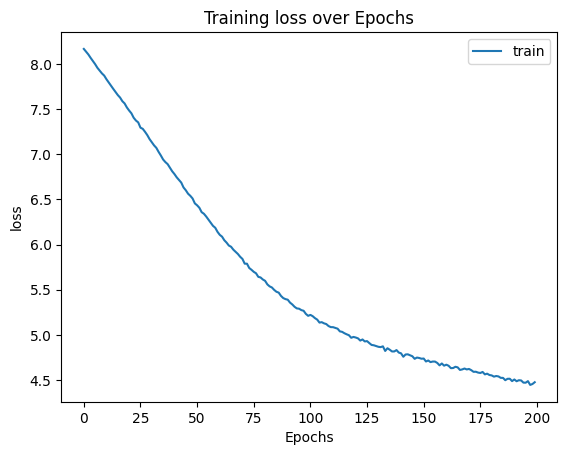

In [ ]:
train_losses = [] 
for epoch in tqdm(range(EPOCHS)) : 
    epoch_loss = 0 
    
    model.train() 
    for src , trg in ds_dataloader : 
        src , trg = src.to(DEVICE) , trg.to(DEVICE) 
        loss = train_step(src , trg) 
        
        epoch_loss += loss 
        
    train_losses.append((epoch_loss / len(ds_dataloader)).cpu().detach().numpy())
    if (epoch + 1) % 20 == 0 :    
            print(f"\n[Epoch :  {epoch+1}/{EPOCHS}] [Train Loss : {train_losses[-1]:0.2f}]\n")
        
plt.plot(train_losses , label='train')
plt.title('Training loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

# <b>8 <span style='color:#9146ff'>|</span> Evaluate</b>

In [ ]:
def evaluate(sent) : 
    sentence = src_tokenizer.texts_to_sequences([sent]) 
    sentence = pad_sequences(sentence , maxlen = SRC_MAXLEN , padding = 'post') 
    
    src_input = torch.tensor(np.array(sentence) , dtype = torch.int64).to(DEVICE) 
    
    decoder_input = trg_tokenizer.texts_to_sequences(['<sos>']) 
    decoder_input = pad_sequences(decoder_input , maxlen = 1 , padding = 'post')
    decoder_input = torch.tensor(np.array(decoder_input) , dtype = torch.int64).to(DEVICE)
    
    for i in range(TRG_MAXLEN) :  
        preds = model(src_input , decoder_input)
        
        preds = preds[: , -1: , :] # (batch_size, 1, vocab_size) 
        
        predicted_id = torch.argmax(preds, dim=-1) 
        
        if predicted_id.item() == trg_tokenizer.word_index['<eos>'] : 
            return decoder_input.squeeze(0) 
        
        decoder_input = torch.cat([decoder_input , predicted_id] , dim = 1) 
        
    return decoder_input.squeeze(0)

In [ ]:
test_sample = df.sample(100)
x_test = test_sample['src'].tolist() 
y_test = test_sample['trg'].tolist()

In [ ]:
for idx , (src_sent , trg_sent) in enumerate(zip(x_test[-10:] , y_test[-10:])) : 
    result = evaluate(src_sent) 
    pred_sent = ' '.join([trg_tokenizer.index_word[idx] for idx in result.cpu().numpy() if idx != 0 and idx != 2])
    print(f"Input sentence {idx+1} : {src_sent}")
    print(f"Actual translation {idx+1} : {trg_sent}")
    print(f"Predicted translation {idx+1} : {pred_sent}\n")

Input sentence 1 : have you ever seen a koala
Actual translation 1 : <sos> sos तुमने कभी क्वाला देखा है eos <eos>
Predicted translation 1 : eos eos eos eos eos eos eos eos eos eos eos eos eos eos की

Input sentence 2 : this is a picture of my sister
Actual translation 2 : <sos> sos यह मेरी बहन की तस्वीर है eos <eos>
Predicted translation 2 : वह eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos की

Input sentence 3 : i cant walk any further
Actual translation 3 : <sos> sos मैं और नहीं चल सकती eos <eos>
Predicted translation 3 : मैं वह वह eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos

Input sentence 4 : the car raised a cloud of dust
Actual translation 4 : <sos> sos उस गाड़ी ने बहुत धूल उड़ाई eos <eos>
Predicted translation 4 : eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos

Input sentence 5 : it is not till we lose our health that we realize its true value
Actual translation 5 : <sos> sos हम जब तक अपनी सेहत नहीं खो देते हैं हमे तब तक उसकी असली कीमत न